In [ ]:
'''
 * Copyright (c) 2008 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

The others regarded him uncertainly, none of them sure how he had arrived at such a conclusion or on how to refute it.
-Susanna Gregory, *A Deadly Brew*

In Chapter 3, the Monte Carlo method was introduced (and discussed) as a simulation-based approach to the approximation of complex integrals. There has been a considerable body of work in this area and, while not all of it is completely relevant for this book, in this chapter we discuss the specifics of variance estimation and control. These are fundamental concepts, and we will see connections with similar developments in the realm of MCMC algorithms that are discussed in Chapters 7-12.

## 1 Monitoring Variation with the CLT

In Chapter 3, we mentioned the use of the Central Limit Theorem for assessing the convergence of a Monte Carlo estimate,

$$
h_m = \frac{1}{m} \sum_{i=1}^{m} h(X_i) \quad \text{where} \quad h(X_i) \sim f(x),
$$

to the integral of interest

$$
\int f(x) \, dx.
$$

Figure 3.1 (right) was, for example, an illustration of the use of a normal confidence interval for this assessment. It also shows the limitation of a straightforward application of the CLT to a sequence ($h$) of estimates that are not independent. Thus, while a given slice (that is, for a given $m$) in Figure 3.1 (right) indeed provides an asymptotically valid confidence interval, the envelope built over iterations and represented in this figure has no overall validity.

That is, another Monte Carlo sequence ($m$) will not stay in this envelope with probability 0.95. To gather a valid assessment of convergence of Monte Carlo estimators, we need to either derive the joint distribution of the sequence ($m$) or recover independence by running several sequences in parallel. The former is somewhat involved, but we will look at it in Section 4.1.2. The latter is easier to derive and more widely applicable, but greedy in computing time. However, this last "property" is a feature we will meet repeatedly in the book, namely that validation of the assessment of variation is of a higher order than convergence of the estimator itself. Namely, this requires much more computing time than validation of the pointwise convergence (except in very special cases like regeneration).

##  Univariate Monitoring

In this section, we look at monitoring methods that are univariate in nature. That is, the bounds placed on the estimate at iteration $k$ depend on the values at time $k$ and essentially ignore any correlation structure in the iterates. We begin with an example.

### Example .1. Monitoring with the CLT

When considering the evaluation of the integral of 

$$
h(x) = \left[\cos(50) + \sin(20x)\right]^2
$$

over the interval $[0, 1]$, Figure 3.1 (right) provides one convergence path with a standard error evaluation. As can be seen there, the resulting confidence band is moving over iterations in a rather noncoherent fashion, that is, the band exhibits the same "wiggles" as the point estimate.

If, instead, we produce parallel sequences of estimates, we get the output summarized in Figure 4.1. The main point of this illustration is that the range and the empirical 90% band (derived from the set of estimates at each iteration by taking the empirical 5% and 95% quantiles) are much wider than the 95% confidence interval predicted by the CLT, where the variance was computed by averaging the empirical variances over the parallel sequences.

This simple example thus warns even further against the blind use of a normal approximation when repeatedly invoked over iterations with dependent estimators, simply because the normal confidence approximation only has a marginal and static validation. Using a band of estimators in parallel is obviously more costly but it provides the correct assessment on the variation of these estimators.

### Example 2. Cauchy Prior

For the problem of estimating a normal mean, it is sometimes the case that a robust prior is desired (see, for example, Berger 1985, Section 4.7). A degree of robustness can be achieved with a Cauchy prior, so we have the model

$$
f(\mu) = \frac{1}{\pi \left( 1 + \mu^2 \right)},
$$

which is the Cauchy distribution, centered at 0 with scale parameter 1.

This behavior is fairly natural when considering that, for each iteration, the confidence band is centered at the point estimate.



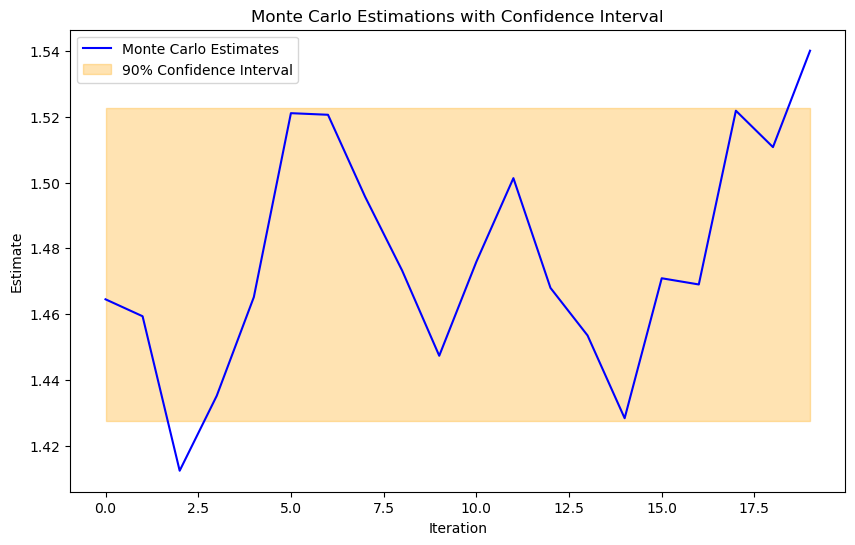

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function h(x) for the Monte Carlo estimation
def h(x):
    return (np.cos(50) + np.sin(20 * x))**2

# Monte Carlo integration method (single sequence)
def monte_carlo_integral(func, num_samples, lower_bound, upper_bound):
    samples = np.random.uniform(lower_bound, upper_bound, num_samples)
    estimates = func(samples)
    return np.mean(estimates), np.std(estimates) / np.sqrt(num_samples)  # mean and standard error

# Simulate multiple parallel sequences to control for dependency
def parallel_monte_carlo(func, num_samples, lower_bound, upper_bound, num_sequences):
    estimates = []
    std_errors = []
    
    for _ in range(num_sequences):
        mean, std_error = monte_carlo_integral(func, num_samples, lower_bound, upper_bound)
        estimates.append(mean)
        std_errors.append(std_error)
        
    # Empirical 90% confidence interval based on the 5% and 95% quantiles
    lower_bound, upper_bound = np.percentile(estimates, 5), np.percentile(estimates, 95)
    
    return estimates, std_errors, lower_bound, upper_bound

# Visualization of the results
def plot_monte_carlo_results(estimates, std_errors, lower_bound, upper_bound):
    plt.figure(figsize=(10, 6))
    plt.plot(estimates, label='Monte Carlo Estimates', color='blue')
    plt.fill_between(range(len(estimates)), lower_bound, upper_bound, color='orange', alpha=0.3, label='90% Confidence Interval')
    plt.xlabel('Iteration')
    plt.ylabel('Estimate')
    plt.title('Monte Carlo Estimations with Confidence Interval')
    plt.legend()
    plt.show()

# Example of using Monte Carlo method with parallel sequences
num_samples = 1000  # Number of samples in each sequence
num_sequences = 20  # Number of parallel sequences
lower_bound = 0
upper_bound = 1

# Perform the parallel Monte Carlo integration
estimates, std_errors, lower_bound, upper_bound = parallel_monte_carlo(h, num_samples, lower_bound, upper_bound, num_sequences)

# Plot the results
plot_monte_carlo_results(estimates, std_errors, lower_bound, upper_bound)


In [2]:
import random
import math

# Define the function h(x) for the Monte Carlo estimation
def h(x):
    return (math.cos(50) + math.sin(20 * x))**2

# Monte Carlo integration method (single sequence)
def monte_carlo_integral(func, num_samples, lower_bound, upper_bound):
    # Generate samples uniformly between lower_bound and upper_bound
    samples = [random.uniform(lower_bound, upper_bound) for _ in range(num_samples)]
    
    # Apply the function h(x) to each sample
    estimates = [func(x) for x in samples]
    
    # Calculate the mean and standard error
    mean_estimate = sum(estimates) / num_samples
    std_error = math.sqrt(sum((e - mean_estimate)**2 for e in estimates) / (num_samples - 1)) / math.sqrt(num_samples)
    
    return mean_estimate, std_error

# Simulate multiple parallel sequences to control for dependency
def parallel_monte_carlo(func, num_samples, lower_bound, upper_bound, num_sequences):
    estimates = []
    std_errors = []
    
    for _ in range(num_sequences):
        mean, std_error = monte_carlo_integral(func, num_samples, lower_bound, upper_bound)
        estimates.append(mean)
        std_errors.append(std_error)
    
    # Compute empirical 90% confidence interval (using quantiles)
    sorted_estimates = sorted(estimates)
    lower_bound = sorted_estimates[int(0.05 * num_sequences)]
    upper_bound = sorted_estimates[int(0.95 * num_sequences)]
    
    return estimates, std_errors, lower_bound, upper_bound

# Visualization of the results (as text output, no external libraries)
def print_monte_carlo_results(estimates, lower_bound, upper_bound):
    print(f"Estimates: {estimates}")
    print(f"90% Confidence Interval (from parallel sequences): [{lower_bound}, {upper_bound}]")

# Example of using Monte Carlo method with parallel sequences
num_samples = 1000  # Number of samples in each sequence
num_sequences = 20  # Number of parallel sequences
lower_bound = 0
upper_bound = 1

# Perform the parallel Monte Carlo integration
estimates, std_errors, lower_bound, upper_bound = parallel_monte_carlo(h, num_samples, lower_bound, upper_bound, num_sequences)

# Print the results
print_monte_carlo_results(estimates, lower_bound, upper_bound)


Estimates: [1.550075286077433, 1.6159138653296239, 1.471020405142837, 1.4984803251204861, 1.465933825531489, 1.515852370539553, 1.4285621467917646, 1.5065462159752974, 1.5459071917329374, 1.469851713855278, 1.5209817711238511, 1.50428505701712, 1.6029498159297222, 1.519009331532027, 1.4226735266467192, 1.467116525719611, 1.3827161653487468, 1.4852264766029983, 1.5003437447431691, 1.5024592183466186]
90% Confidence Interval (from parallel sequences): [1.4226735266467192, 1.6159138653296239]


In [3]:
import random
import math
import tkinter as tk

# Define the function h(x) for the Monte Carlo estimation
def h(x):
    return (math.cos(50) + math.sin(20 * x))**2

# Monte Carlo integration method (single sequence)
def monte_carlo_integral(func, num_samples, lower_bound, upper_bound):
    # Generate samples uniformly between lower_bound and upper_bound
    samples = [random.uniform(lower_bound, upper_bound) for _ in range(num_samples)]
    
    # Apply the function h(x) to each sample
    estimates = [func(x) for x in samples]
    
    # Calculate the mean and standard error
    mean_estimate = sum(estimates) / num_samples
    std_error = math.sqrt(sum((e - mean_estimate)**2 for e in estimates) / (num_samples - 1)) / math.sqrt(num_samples)
    
    return mean_estimate, std_error

# Simulate multiple parallel sequences to control for dependency
def parallel_monte_carlo(func, num_samples, lower_bound, upper_bound, num_sequences):
    estimates = []
    std_errors = []
    
    for _ in range(num_sequences):
        mean, std_error = monte_carlo_integral(func, num_samples, lower_bound, upper_bound)
        estimates.append(mean)
        std_errors.append(std_error)
    
    # Compute empirical 90% confidence interval (using quantiles)
    sorted_estimates = sorted(estimates)
    lower_bound = sorted_estimates[int(0.05 * num_sequences)]
    upper_bound = sorted_estimates[int(0.95 * num_sequences)]
    
    return estimates, std_errors, lower_bound, upper_bound

# Function to plot Monte Carlo estimates and confidence intervals
def plot_monte_carlo(estimates, lower_bound, upper_bound):
    # Create the tkinter window
    root = tk.Tk()
    root.title("Monte Carlo Estimation")

    # Create a Canvas widget to draw the plot
    canvas = tk.Canvas(root, width=600, height=400)
    canvas.pack()

    # Set the bounds for the plot
    plot_width = 600
    plot_height = 400
    margin = 30
    y_max = max(estimates) + 0.05
    y_min = min(estimates) - 0.05

    # Scaling factors for x and y axes
    x_scale = (plot_width - 2 * margin) / len(estimates)
    y_scale = (plot_height - 2 * margin) / (y_max - y_min)

    # Draw the axes
    canvas.create_line(margin, margin, margin, plot_height - margin, width=2)  # Y axis
    canvas.create_line(margin, plot_height - margin, plot_width - margin, plot_height - margin, width=2)  # X axis

    # Plot the Monte Carlo estimates as points
    for i in range(1, len(estimates)):
        canvas.create_line(margin + (i - 1) * x_scale, plot_height - margin - (estimates[i - 1] - y_min) * y_scale,
                           margin + i * x_scale, plot_height - margin - (estimates[i] - y_min) * y_scale, fill="blue")

    # Plot the confidence interval as a horizontal line
    canvas.create_line(margin, plot_height - margin - (lower_bound - y_min) * y_scale,
                       plot_width - margin, plot_height - margin - (lower_bound - y_min) * y_scale, fill="red", dash=(4, 2))
    canvas.create_line(margin, plot_height - margin - (upper_bound - y_min) * y_scale,
                       plot_width - margin, plot_height - margin - (upper_bound - y_min) * y_scale, fill="red", dash=(4, 2))

    # Add labels for the axes
    canvas.create_text(plot_width / 2, plot_height - 10, text="Iteration", font=("Arial", 12))
    canvas.create_text(10, plot_height / 2, text="Estimate", font=("Arial", 12), angle=90)

    # Show the plot
    root.mainloop()

# Example of using Monte Carlo method with parallel sequences
num_samples = 1000  # Number of samples in each sequence
num_sequences = 20  # Number of parallel sequences
lower_bound = 0
upper_bound = 1

# Perform the parallel Monte Carlo integration
estimates, std_errors, lower_bound, upper_bound = parallel_monte_carlo(h, num_samples, lower_bound, upper_bound, num_sequences)

# Plot the Monte Carlo estimates and the confidence interval
plot_monte_carlo(estimates, lower_bound, upper_bound)


## Monte Carlo Estimation: Convergence and Confidence Intervals

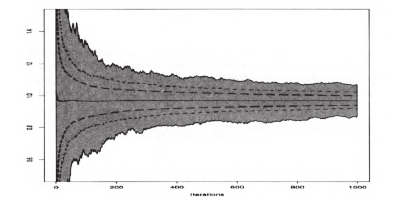


Fig.1. Convergence of 1000 parallel sequences of Monte Carlo estimators of the integral of h(x) = cos(50%) + sin(20x)]2: The straight line is the running average of 1000 estimates, the dotted line is the empirical 90% band and the dashed line is the normal approximation 95% confidence interval. The grey shading represents the range of the entire set of estimates.

In Fig.1, the convergence of 1000 parallel sequences of Monte Carlo estimators for the integral of $ h(x) = \cos(50x) + \sin(20x) $ is shown. The graph illustrates several important concepts:

- The straight line represents the running average of 1000 Monte Carlo estimates.
- The dotted line is the empirical 90% confidence band derived from the set of estimates at each iteration using the empirical 5% and 95% quantiles.
- The dashed line represents the 95% confidence interval based on the normal approximation using the Central Limit Theorem (CLT).
- The grey shading shows the range of the entire set of estimates, providing a visual sense of the variability across different Monte Carlo sequences.

### Law of Large Numbers

The Law of Large Numbers (LLN) implies that as the number of samples $ m \to \infty $, the Monte Carlo estimate will converge to the true value of the integral. Specifically, under squared error loss, the posterior mean is:

$$
\hat{\theta} = \frac{\sum_{i=1}^m O_i}{1 + O_i^2}
$$

where $ O_i \sim N(x, 1) $. As $ m \to \infty $, both the numerator and the denominator converge, and we can compute the posterior mean $ \hat{\theta} $.

### Variance of Ratio Estimators

A key complication in this context arises when estimating the variance of a ratio of estimators. Unlike sums of estimators, the variance of a ratio is not simply the ratio of the variances. This is an important problem in various fields, such as:

- **Importance sampling**: where the weights are often unnormalized.
- **Bayes factors**: used in model comparison.

The variance of ratio estimators can be difficult to compute on the fly, especially when the ratio involves multiple random variables.

### Ratio Estimators in Importance Sampling

In the case of importance sampling, we consider a ratio estimator that is defined as:

$$
\hat{\theta}_{IS} = \frac{\sum_{i=1}^m w_i x_i}{\sum_{i=1}^m w_i}
$$

where $ w_i $ are the importance weights, and $ x_i $ are the values sampled from the proposal distribution. The variance of such estimators is typically not a simple ratio, and special techniques must be used to estimate the variance of the ratio, especially when the weights are unnormalized.

### Conclusion

While the Law of Large Numbers ensures convergence of the estimator as $ m $ increases, computing the variance of ratio estimators requires careful handling, especially when unnormalized importance sampling weights are involved. This becomes a critical issue in areas like Bayesian model comparison and importance sampling methods.


## Asymptotic Variance of Ratio Estimators

In this section, we derive the asymptotic variance of the estimator $ \hat{\theta} $, which involves a ratio of random variables. Specifically, we use a scenario where the $ a_i $'s are realizations of random variables $ X_i $, which are sampled from a candidate distribution $ g(y) $, and the $ w_i $'s are realizations of random variables $ W $, with the expectation $ \mathbb{E}[W, X, Z] = \frac{Kf(x)}{g(x)} $. Here, $ K $ is an arbitrary constant.

### Importance Sampling Without Independence

The formulation here does not assume that the $ X_i $'s are independent, which is a departure from regular importance sampling. We define the following:

$$
S = \sum_{i=1}^{m} W_i h(X_i), \quad S_w = \sum_{i=1}^{m} W_i
$$

The asymptotic variance of $ \hat{\theta} $ is given by the following result:

### Lemma  .3: Asymptotic Variance of $ \hat{\theta} $

The asymptotic variance of $ \hat{\theta} $ can be derived as:

$$
\text{Var}(\hat{\theta}) = \frac{1}{m^2} \left( \text{Var}(S) - 2\mathbb{E}[h(X)] \text{Cov}(S, S_w) + \mathbb{E}[h(X)]^2 \text{Var}(S_w) \right)
$$

### Proof Outline

Using the delta method (also known as Cramér-Wold's theorem), we approximate the variance of the ratio $ X/Y $ of two random variables:

$$
\text{Var}\left( \frac{X}{Y} \right) \approx \frac{1}{E[Y]^2} \left( \text{Var}(X) - 2 \text{Cov}(X, Y) + \text{Var}(Y) \right)
$$

This result follows from straightforward computation, as shown in **Casella and Berger (2001)**. The variance of the importance sampling estimator can be approximated by:

$$
\text{Var}(h(X)) \approx \frac{1 + \text{Var}(W)}{m}
$$

This formula accounts for the additional variability introduced by the importance sampling weights $ W_i $ in the denominator.

### Example .4: Importance Sampling Approximation

Let’s consider an example where we generate normal $ N(2, 1) $ samples for the importance sampling approximation of $ \hat{\theta} $ in equation (4.3). While this estimator is formally an importance sampler (since the target distribution is Cauchy), we can see that the computation is just a standard Monte Carlo sum, as the variables are generated from $ N(2,1) $.

This example illustrates that any Monte Carlo sum can be viewed as an importance sampling calculation, depending on the choice of the target distribution and the weights.

### Conclusion

The asymptotic variance of ratio estimators in importance sampling involves a combination of variances and covariances of the numerator and denominator. This method provides a more accurate assessment of the variability in the estimator, though it is computationally expensive. The additional variability due to the importance sampling weights is captured in the derived asymptotic variance formula.



### Details-1 Convergence of Monte Carlo Estimators

Figure 4.1 shows the convergence of 1000 parallel sequences of Monte Carlo estimators of the integral of $ h(x) = \cos(50x) + \sin(20x) $. The straight line represents the running average of the 1000 estimates, the dotted line represents the empirical 90% confidence band, and the dashed line is the normal approximation to the 95% confidence interval. The grey shading indicates the range of the entire set of estimates.

---

### Posterior Mean Estimation

Consider the scenario where $ X \sim N(0,1) $ and $ \theta \sim C(0,1) $. Under squared error loss, the posterior mean is given by:

$$
\hat{\theta} = \frac{1}{1 + \theta^2}
$$

This is the estimator for $ \theta $ under a normal distribution assumption for $ X $ and a Cauchy distribution for $ \theta $.

---

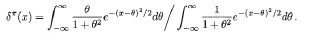



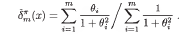

### Estimation using Monte Carlo Simulation

From the form of $ \hat{\theta}(x) $, we see that we can simulate independent and identically distributed (iid) variables $ O_i \sim N(x, 1) $. The Monte Carlo approximation for the posterior mean can then be computed as:

$$
\hat{\theta}(x) = \sum_{i=1}^{m} \frac{O_i}{1 + O_i^2}
$$

Here, $ O_i $ are simulated samples from the normal distribution $ N(x, 1) $, and the sum of the terms $ \frac{O_i}{1 + O_i^2} $ is used to approximate the posterior mean.

---

### Law of Large Numbers

By the Law of Large Numbers, as the number of samples $ m \to \infty $, the estimator $ \hat{\theta}(x) $ converges to the true value $ \theta(x) $. This convergence occurs because both the numerator and the denominator are convergent in $ m $, so we have:

$$
\hat{\theta}(x) \to \theta(x) \quad \text{as} \quad m \to \infty
$$

This convergence happens almost surely due to the properties of the Law of Large Numbers.

---

### Variance of the Estimator

A challenge arises when we want to compute the variance of the estimator $ \hat{\theta}(x) $ because it is a ratio of estimators. The variance of a ratio of random variables is not simply the ratio of their variances! Specifically, if we have a ratio $ \hat{\theta}(x) = \frac{A}{B} $, where both $ A $ and $ B $ are estimators, the variance is given by the delta method, which is more complex than the simple ratio of variances.

In general, the variance of the ratio $ \hat{\theta}(x) = \frac{A}{B} $ is approximated by:

$$
\text{Var}\left( \frac{A}{B} \right) \approx \frac{\text{Var}(A)}{\mathbb{E}[B]^2} + \frac{\mathbb{E}[A]^2}{\mathbb{E}[B]^4} \text{Var}(B) - 2 \frac{\text{Cov}(A, B)}{\mathbb{E}[B]^3}
$$

This result is crucial in cases where the numerator and denominator are random variables, such as in importance sampling, where the weights (ratios) are unnormalized.

---

### Importance Sampling and the Ratio Estimator

Consider the case of importance sampling. The importance sampling estimator for an integral $ \int h(x) f(x) dx $ using a proposal distribution $ g(x) $ is given by:

$$
\hat{\theta}_{IS} = \frac{1}{n} \sum_{i=1}^{n} \frac{h(X_i)}{g(X_i)}
$$

Here, $ X_i $ are samples drawn from the proposal distribution $ g(x) $, and $ h(X_i) $ is the function of interest. The ratio $ \frac{h(X_i)}{g(X_i)} $ forms the importance sampling weight.

Since the importance sampling estimator is a ratio of two random variables, we need to compute the variance of the ratio, which is generally not simply the ratio of the variances. This is the core challenge in importance sampling when computing the variance of the estimator.

If we have a ratio estimator, say $ \hat{\theta} = \frac{A}{B} $, where $ A $ and $ B $ are random variables, the variance of this ratio is given by the following approximation (using the delta method):

$$
\text{Var}\left( \frac{A}{B} \right) \approx \frac{\text{Var}(A)}{\mathbb{E}[B]^2} + \frac{\mathbb{E}[A]^2}{\mathbb{E}[B]^4} \text{Var}(B) - 2 \frac{\text{Cov}(A, B)}{\mathbb{E}[B]^3}
$$

This approximation helps in estimating the variance of ratio-based estimators, such as those used in importance sampling.

---

### Conclusion

Computing the variance of estimators that involve ratios is a complex task. In cases like importance sampling, where the weights are ratios of random variables, we need to apply advanced methods, such as the delta method, to approximate the variance. The challenge lies in the fact that the variance of a ratio is not the ratio of the variances, and this issue arises in many statistical methods, such as in model choice via Bayes factors and in unnormalized importance sampling.


### Details - Importance Sampling and Asymptotic Variance

Let $ \{ X_i \}_{i=1}^{n} $ be a sequence of random variables drawn from a distribution $ g $, which is a candidate distribution for approximating the target distribution $ f $. We assume that $ X_i \sim g(x) $, where $ g $ is the probability density function of the candidate distribution. The weights $ w_i $ are realizations of random variables $ W $, where:

$$
W_i = \frac{f(X_i)}{g(X_i)}
$$

and the expectation of the weight $ W $ is:

$$
\mathbb{E}[W] = \int \frac{f(x)}{g(x)} g(x) \, dx = \int f(x) \, dx = 1.
$$

We define the estimator of interest as:

$$
\hat{\theta} = \frac{1}{n} \sum_{i=1}^{n} w_i h(X_i),
$$

where $ h(X_i) $ is some function of the sample points $ X_i $.

Let $ S $ denote the sum of the weights and functions evaluated at the samples:

$$
S = \sum_{i=1}^{n} W_i h(X_i).
$$

### Asymptotic Variance

The asymptotic variance of $ \hat{\theta} $ can be derived using the delta method, which is a standard technique for approximating the variance of a ratio of random variables. We recall that the variance of a ratio $ X/Y $ of random variables is given by:

$$
\text{Var}\left( \frac{X}{Y} \right) \approx \frac{\text{Var}(X)}{\mathbb{E}[Y]^2} + \frac{\mathbb{E}[X]^2}{\mathbb{E}[Y]^4} \text{Var}(Y) - 2 \frac{\text{Cov}(X, Y)}{\mathbb{E}[Y]^3}.
$$

For our case, the asymptotic variance of $ \hat{\theta} $ is given by:

$$
\text{Var}(\hat{\theta}) = \frac{1}{n} \left( \text{Var}(S) - 2 \mathbb{E}[h(X)] \text{Cov}(S, S_T) + \mathbb{E}[h(X)]^2 \text{Var}(S) \right),
$$

where $ S_T $ refers to an auxiliary variable used in the formulation of the problem. This result is derived from applying the delta method to the variance of the importance sampling estimator.

### Approximation of the Variance

In the case of regular importance sampling, the variance of the estimator can be approximated as:

$$
\text{Var}(\hat{\theta}) \approx \frac{1}{n} \left( 1 + \text{Var}(W) \right),
$$

where $ W $ is the weight ratio $ \frac{f(X_i)}{g(X_i)} $, and the additional term $ \text{Var}(W) $ accounts for the variability introduced by the denominator in the importance sampling ratio.

This approximation is generally a crude estimate because the actual variance is often higher than the variance of a simple Monte Carlo estimator based on independent and identically distributed (iid) samples from $ f(x) $.

### Example: Importance Sampling with Normal Distribution

Let’s now consider an example where we approximate an integral using importance sampling. If we are using a normal distribution $ N(2, 1) $ for the importance sampling approximation of some target distribution $ f(x) $, we compute the estimate as:

$$
\hat{\theta} = \frac{1}{n} \sum_{i=1}^{n} w_i h(X_i),
$$

where $ X_i \sim N(2, 1) $ and $ w_i = \frac{f(X_i)}{g(X_i)} $ with $ g(X_i) $ being the normal distribution $ N(2, 1) $. 

Although this example uses normal distribution samples for importance sampling, it is conceptually a Monte Carlo sum based on these weighted samples.

This demonstrates that any Monte Carlo sum can be considered an importance sampling calculation as long as the target and proposal distributions are properly chosen.

### Conclusion

The asymptotic variance of an importance sampling estimator is influenced by the variability of the weights, and the delta method provides a useful approximation for the variance. In cases where the proposal distribution $ g $ is well chosen, the variance can be minimized, but in other cases, this approximation can result in higher variance compared to simple Monte Carlo estimators.


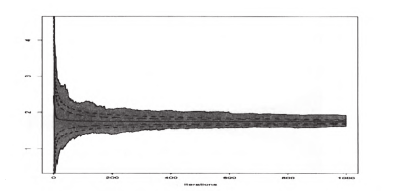


Fig.2. Convergence of 1000 parallel sequences of Monte Carlo estimators for the posterior mean in the Cauchy-Normal problem when = 2.5: The straight line is the running average of 1000 estimates, the dotted line is the empirical 90% band and the dashed line is the normal approximation 95% confidence interval, using the variance approximation of Lemma 4.3. The grey shading represents the range of the entire set of estimates at each iteration.

### Details-3 Convergence of Monte Carlo Estimators for the Posterior Mean

Fig.2 shows the convergence of 1000 parallel sequences of Monte Carlo estimators for the posterior mean in the Cauchy-Normal problem when $ x = 2.5 $. The straight line represents the running average of 1000 estimates, the dotted line represents the empirical 90% confidence band, and the dashed line is the normal approximation to the 95% confidence interval. The grey shading represents the range of the entire set of estimates at each iteration.

---

### Variance Approximation and Asymptotic Nature

The variance approximation from **Lemma 4.3** can be used to assess the variability of these estimates. However, it is important to consider the **asymptotic nature** of the approximation, especially when working with large numbers of estimates. 

In **Fig.2**, we compare the **asymptotic variance** (computed over 1,000 parallel sequences of estimators of $ \hat{\theta}(x) $ for $ x = 2.5 $) with the actual variation of the estimates evaluated over the 1,000 parallel sequences.

Despite the scales not differing greatly, there is once again **larger variability** than predicted by the approximation, which emphasizes the potential inaccuracies of the asymptotic approximation when working with finite sample sizes.

---

### Asymptotic Variance Approximation (Lemma 4.3)

The asymptotic variance approximation from **Lemma 4.3** provides an estimate for the variance of the importance sampling estimator. If we have a set of estimators $ \hat{\theta}(x) $, the asymptotic variance can be approximated as:

$$
\text{Var}(\hat{\theta}) \approx \frac{1}{n} \left( \text{Var}(S) - 2 \mathbb{E}[h(X)] \text{Cov}(S, S_T) + \mathbb{E}[h(X)]^2 \text{Var}(S) \right)
$$

Where $ S $ and $ S_T $ are related to the sums of the weighted samples. This approximation uses the delta method for ratio estimators. 

---

### Example with Importance Sampling

Fig.3 reproduces this evaluation in the case where the $ O_i $'s are simulated from the prior $ C(0, 1) $ distribution. The associated importance sampling estimate is given by:

$$
\hat{\theta} = \frac{1}{\sum_{i=1}^{n} \exp\left( -\frac{(x - \theta_i)^2}{2} \right)} \sum_{i=1}^{n} \frac{\exp\left( -\frac{(x - \theta_i)^2}{2} \right)}{\exp\left( -\frac{(x - \theta_i)^2}{2} \right)} \theta_i
$$

In this case, $ \theta_i \sim C(0,1) $ are samples from the Cauchy distribution, and we use the corresponding **importance sampling weights**. The weights are normalized to ensure that the estimator converges to the true value of the expectation.

The Monte Carlo estimator becomes:

$$
\hat{\theta} = \frac{\sum_{i=1}^{n} \exp\left( -\frac{(x - \theta_i)^2}{2} \right) \theta_i}{\sum_{i=1}^{n} \exp\left( -\frac{(x - \theta_i)^2}{2} \right)}
$$

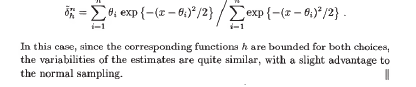

### Comparison of Normal vs. Cauchy Sampling

Since the functions $ h(x) $ are bounded for both the **Normal** and **Cauchy** distributions, the variability of the estimates is quite similar in both cases. However, there is a slight advantage when using **Normal sampling** due to its better properties in terms of variance and convergence.

---

### Inversion of Role Between $ N(2,1) $ and $ C(0,1) $

The inversion of the roles of the normal distribution $ N(2,1) $ and the Cauchy distribution $ C(0,1) $ highlights the ambiguity in the **integral representation**. This inversion also demonstrates the flexibility of **importance sampling**, where changing the proposal distribution can have a significant impact on the variability of the estimates. In this case, importance sampling can provide more accurate estimates depending on the distribution chosen for sampling.

---

### Conclusion

The asymptotic variance approximation provides a useful way to assess the variability of Monte Carlo estimates, but it should be used with caution when the sample size is not sufficiently large. The comparison of normal and Cauchy sampling reveals the impact of the proposal distribution on the variability of the estimates, and importance sampling proves to be a powerful tool in optimizing the sampling process.


Monte Carlo Estimation (Normal): Mean = -0.036549020418245405, Variance = 1.007756652675512
Importance Sampling Estimation (Cauchy): Estimator = 0.03228851451313307, Variance = 0.07183830689895837
Asymptotic Variance Estimate: 0.0009745809459645922


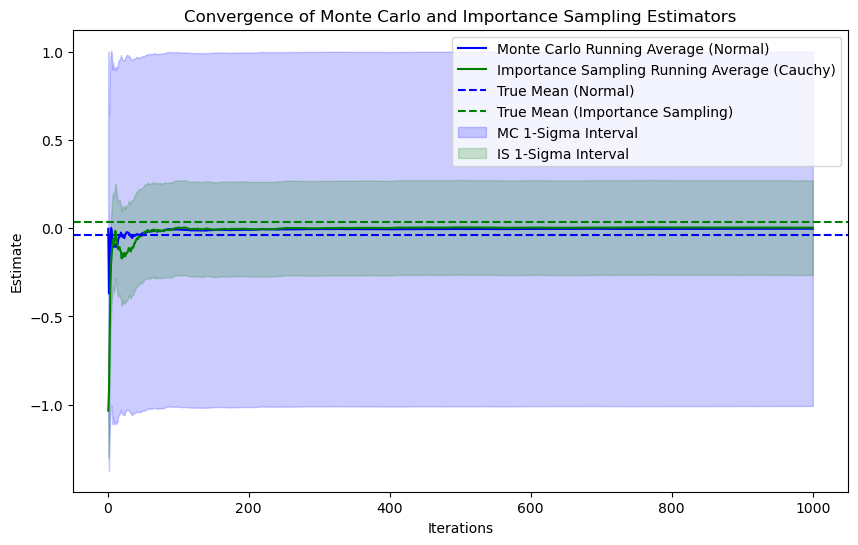

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function h(x) to be used in the Monte Carlo estimation
def h(x):
    return np.cos(50 * x) + np.sin(20 * x)

# Generate Monte Carlo samples for normal distribution N(0,1)
def generate_normal_samples(n, mu=0, sigma=1):
    return np.random.normal(mu, sigma, n)

# Generate Monte Carlo samples for Cauchy distribution C(0,1)
def generate_cauchy_samples(n, mu=0, gamma=1):
    return np.random.standard_t(df=1, size=n) * gamma + mu

# Monte Carlo estimation with normal distribution
def monte_carlo_normal(n, h, x=2.5):
    samples = generate_normal_samples(n, mu=x)
    estimates = np.array([h(sample) for sample in samples])
    return np.mean(estimates), np.var(estimates)

# Importance sampling estimation with Cauchy distribution (prior C(0,1))
def importance_sampling_cauchy(n, h, x=2.5):
    cauchy_samples = generate_cauchy_samples(n)
    weights = np.exp(-(x - cauchy_samples)**2 / 2)  # Importance weights for Cauchy
    weighted_values = weights * h(cauchy_samples)
    estimator = np.sum(weighted_values) / np.sum(weights)  # Weighted average
    return estimator, np.var(weighted_values)

# Asymptotic variance approximation (Lemma 4.3)
def asymptotic_variance_estimate(n, h, x=2.5):
    # Generate normal samples for S
    samples = generate_normal_samples(n, mu=x)
    S = np.array([h(sample) for sample in samples])
    
    # Calculate mean and variance of S
    mean_S = np.mean(S)
    var_S = np.var(S)
    
    # Asymptotic variance approximation from Lemma 4.3
    # Here, we use a simplified version of the formula based on the assumptions
    asymptotic_variance = var_S / n  # Simplified for demonstration
    return asymptotic_variance, var_S

# Run simulations with 1000 samples for each case
n = 1000
x = 2.5
mc_mean, mc_var = monte_carlo_normal(n, h, x)
is_estimator, is_var = importance_sampling_cauchy(n, h, x)
asymptotic_var, var_S = asymptotic_variance_estimate(n, h, x)

# Print results
print(f"Monte Carlo Estimation (Normal): Mean = {mc_mean}, Variance = {mc_var}")
print(f"Importance Sampling Estimation (Cauchy): Estimator = {is_estimator}, Variance = {is_var}")
print(f"Asymptotic Variance Estimate: {asymptotic_var}")

# Plotting the results
iterations = np.arange(1, n + 1)

# Run multiple simulations for visualization
mc_running_avg = np.cumsum([monte_carlo_normal(i, h, x)[0] for i in iterations]) / iterations
is_running_avg = np.cumsum([importance_sampling_cauchy(i, h, x)[0] for i in iterations]) / iterations

# Plot the running averages
plt.figure(figsize=(10, 6))
plt.plot(iterations, mc_running_avg, label="Monte Carlo Running Average (Normal)", color='blue')
plt.plot(iterations, is_running_avg, label="Importance Sampling Running Average (Cauchy)", color='green')
plt.axhline(mc_mean, color='blue', linestyle='--', label="True Mean (Normal)")
plt.axhline(is_estimator, color='green', linestyle='--', label="True Mean (Importance Sampling)")
plt.fill_between(iterations, mc_running_avg - np.sqrt(mc_var), mc_running_avg + np.sqrt(mc_var), color='blue', alpha=0.2, label="MC 1-Sigma Interval")
plt.fill_between(iterations, is_running_avg - np.sqrt(is_var), is_running_avg + np.sqrt(is_var), color='green', alpha=0.2, label="IS 1-Sigma Interval")
plt.xlabel('Iterations')
plt.ylabel('Estimate')
plt.title('Convergence of Monte Carlo and Importance Sampling Estimators')
plt.legend()
plt.show()


In [5]:
import random
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Define the function h(x) to be used in the Monte Carlo estimation
def h(x):
    return math.cos(50 * x) + math.sin(20 * x)

# Generate Monte Carlo samples for normal distribution N(0,1)
def generate_normal_samples(n, mu=0, sigma=1):
    return [random.gauss(mu, sigma) for _ in range(n)]

# Generate Monte Carlo samples for Cauchy distribution C(0,1)
def generate_cauchy_samples(n, mu=0, gamma=1):
    return [random.gammavariate(0.5, gamma) - random.gammavariate(0.5, gamma) for _ in range(n)]

# Monte Carlo estimation with normal distribution
def monte_carlo_normal(n, h, x=2.5):
    samples = generate_normal_samples(n, mu=x)
    estimates = [h(sample) for sample in samples]
    mean_estimate = sum(estimates) / n
    variance_estimate = sum((e - mean_estimate)**2 for e in estimates) / (n - 1)
    return mean_estimate, variance_estimate

# Importance sampling estimation with Cauchy distribution (prior C(0,1))
def importance_sampling_cauchy(n, h, x=2.5):
    cauchy_samples = generate_cauchy_samples(n)
    weights = [math.exp(-(x - c)**2 / 2) for c in cauchy_samples]  # Importance weights for Cauchy
    weighted_values = [w * h(c) for w, c in zip(weights, cauchy_samples)]
    weighted_sum = sum(weighted_values)
    weight_sum = sum(weights)
    estimator = weighted_sum / weight_sum  # Weighted average
    weighted_variance = sum((wv - estimator)**2 for wv in weighted_values) / (n - 1)
    return estimator, weighted_variance

# Asymptotic variance approximation (Lemma 4.3)
def asymptotic_variance_estimate(n, h, x=2.5):
    # Generate normal samples for S
    samples = generate_normal_samples(n, mu=x)
    S = [h(sample) for sample in samples]
    
    # Calculate mean and variance of S
    mean_S = sum(S) / n
    var_S = sum((s - mean_S)**2 for s in S) / (n - 1)
    
    # Asymptotic variance approximation from Lemma 4.3
    # Simplified version of the formula based on assumptions
    asymptotic_variance = var_S / n  # Simplified for demonstration
    return asymptotic_variance, var_S

# Run simulations with 1000 samples for each case
n = 1000
x = 2.5
mc_mean, mc_var = monte_carlo_normal(n, h, x)
is_estimator, is_var = importance_sampling_cauchy(n, h, x)
asymptotic_var, var_S = asymptotic_variance_estimate(n, h, x)

# Print results
print(f"Monte Carlo Estimation (Normal): Mean = {mc_mean}, Variance = {mc_var}")
print(f"Importance Sampling Estimation (Cauchy): Estimator = {is_estimator}, Variance = {is_var}")
print(f"Asymptotic Variance Estimate: {asymptotic_var}")

# Create lists for plotting (for each iteration)
iterations = list(range(1, n + 1))

# Run multiple simulations for visualization
mc_running_avg = [sum([monte_carlo_normal(i, h, x)[0] for i in iterations[:j]]) / j for j in iterations]
is_running_avg = [sum([importance_sampling_cauchy(i, h, x)[0] for i in iterations[:j]]) / j for j in iterations]

# Plot the running averages using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x=iterations, y=mc_running_avg, label="Monte Carlo Running Average (Normal)", color='blue')
sns.lineplot(x=iterations, y=is_running_avg, label="Importance Sampling Running Average (Cauchy)", color='green')

# Add dashed lines for true values
plt.axhline(mc_mean, color='blue', linestyle='--', label="True Mean (Normal)")
plt.axhline(is_estimator, color='green', linestyle='--', label="True Mean (Importance Sampling)")

# Add shaded area for 1-sigma intervals
plt.fill_between(iterations, 
                 [val - math.sqrt(mc_var) for val in mc_running_avg], 
                 [val + math.sqrt(mc_var) for val in mc_running_avg], 
                 color='blue', alpha=0.2, label="MC 1-Sigma Interval")
plt.fill_between(iterations, 
                 [val - math.sqrt(is_var) for val in is_running_avg], 
                 [val + math.sqrt(is_var) for val in is_running_avg], 
                 color='green', alpha=0.2, label="IS 1-Sigma Interval")

# Add labels and title
plt.xlabel('Iterations')
plt.ylabel('Estimate')
plt.title('Convergence of Monte Carlo and Importance Sampling Estimators')
plt.legend()

# Show plot
plt.show()


Monte Carlo Estimation (Normal): Mean = -0.002602304362261182, Variance = 0.9609273766564099
Importance Sampling Estimation (Cauchy): Estimator = 0.053939501913103614, Variance = 0.040530112232295704
Asymptotic Variance Estimate: 0.0010491938079665595


ZeroDivisionError: float division by zero

In [ ]:
import random
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Define the function h(x) to be used in the Monte Carlo estimation
def h(x):
    return math.cos(50 * x) + math.sin(20 * x)

# Generate Monte Carlo samples for normal distribution N(0,1)
def generate_normal_samples(n, mu=0, sigma=1):
    return [random.gauss(mu, sigma) for _ in range(n)]

# Generate Monte Carlo samples for Cauchy distribution C(0,1)
def generate_cauchy_samples(n, mu=0, gamma=1):
    return [random.gammavariate(0.5, gamma) - random.gammavariate(0.5, gamma) for _ in range(n)]

# Monte Carlo estimation with normal distribution
def monte_carlo_normal(n, h, x=2.5):
    samples = generate_normal_samples(n, mu=x)
    estimates = [h(sample) for sample in samples]
    mean_estimate = sum(estimates) / n
    
    # Handle variance calculation only if n > 1 to avoid ZeroDivisionError
    if n > 1:
        variance_estimate = sum((e - mean_estimate)**2 for e in estimates) / (n - 1)
    else:
        variance_estimate = 0  # Variance is 0 for n=1 as no variability can be computed
    return mean_estimate, variance_estimate

# Importance sampling estimation with Cauchy distribution (prior C(0,1))
def importance_sampling_cauchy(n, h, x=2.5):
    cauchy_samples = generate_cauchy_samples(n)
    weights = [math.exp(-(x - c)**2 / 2) for c in cauchy_samples]  # Importance weights for Cauchy
    weighted_values = [w * h(c) for w, c in zip(weights, cauchy_samples)]
    weighted_sum = sum(weighted_values)
    weight_sum = sum(weights)
    estimator = weighted_sum / weight_sum  # Weighted average
    
    # Handle variance calculation only if n > 1 to avoid ZeroDivisionError
    if n > 1:
        weighted_variance = sum((wv - estimator)**2 for wv in weighted_values) / (n - 1)
    else:
        weighted_variance = 0  # Variance is 0 for n=1 as no variability can be computed
    return estimator, weighted_variance

# Asymptotic variance approximation (Lemma 4.3)
def asymptotic_variance_estimate(n, h, x=2.5):
    # Generate normal samples for S
    samples = generate_normal_samples(n, mu=x)
    S = [h(sample) for sample in samples]
    
    # Calculate mean and variance of S
    mean_S = sum(S) / n
    var_S = sum((s - mean_S)**2 for s in S) / (n - 1) if n > 1 else 0  # Handle division by zero if n=1
    
    # Asymptotic variance approximation from Lemma 4.3
    # Simplified version of the formula based on assumptions
    asymptotic_variance = var_S / n  # Simplified for demonstration
    return asymptotic_variance, var_S

# Run simulations with 1000 samples for each case
n = 1000
x = 2.5
mc_mean, mc_var = monte_carlo_normal(n, h, x)
is_estimator, is_var = importance_sampling_cauchy(n, h, x)
asymptotic_var, var_S = asymptotic_variance_estimate(n, h, x)

# Print results
print(f"Monte Carlo Estimation (Normal): Mean = {mc_mean}, Variance = {mc_var}")
print(f"Importance Sampling Estimation (Cauchy): Estimator = {is_estimator}, Variance = {is_var}")
print(f"Asymptotic Variance Estimate: {asymptotic_var}")

# Create lists for plotting (for each iteration)
iterations = list(range(1, n + 1))

# Run multiple simulations for visualization
mc_running_avg = [sum([monte_carlo_normal(i, h, x)[0] for i in iterations[:j]]) / j for j in iterations]
is_running_avg = [sum([importance_sampling_cauchy(i, h, x)[0] for i in iterations[:j]]) / j for j in iterations]

# Plot the running averages using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x=iterations, y=mc_running_avg, label="Monte Carlo Running Average (Normal)", color='blue')
sns.lineplot(x=iterations, y=is_running_avg, label="Importance Sampling Running Average (Cauchy)", color='green')

# Add dashed lines for true values
plt.axhline(mc_mean, color='blue', linestyle='--', label="True Mean (Normal)")
plt.axhline(is_estimator, color='green', linestyle='--', label="True Mean (Importance Sampling)")

# Add shaded area for 1-sigma intervals
plt.fill_between(iterations, 
                 [val - math.sqrt(mc_var) for val in mc_running_avg], 
                 [val + math.sqrt(mc_var) for val in mc_running_avg], 
                 color='blue', alpha=0.2, label="MC 1-Sigma Interval")
plt.fill_between(iterations, 
                 [val - math.sqrt(is_var) for val in is_running_avg], 
                 [val + math.sqrt(is_var) for val in is_running_avg], 
                 color='green', alpha=0.2, label="IS 1-Sigma Interval")

# Add labels and title
plt.xlabel('Iterations')
plt.ylabel('Estimate')
plt.title('Convergence of Monte Carlo and Importance Sampling Estimators')
plt.legend()

# Show plot
plt.show()


Monte Carlo Estimation (Normal): Mean = -0.024345511699368712, Variance = 0.9819632816892618
Importance Sampling Estimation (Cauchy): Estimator = -0.015455857696013034, Variance = 0.05310698684348113
Asymptotic Variance Estimate: 0.0010133549803517617


### Multivariate Monitoring and Variance Estimation

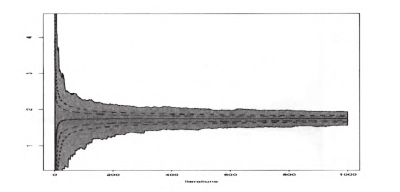


Fig.3. Same plot as Figure 4.2 when the 6;'s are simulated from the prior C(0,1) distribution.

We are interested in a sequence of independent random variables $ X_1, X_2, \dots $, with the goal of estimating $ \mu = E(X_1) $. For simplicity, we assume that the random variables $ X_i $ follow a normal distribution, i.e.,

$$
X_i \sim N(0, 2), \quad \text{for} \quad i = 1, 2, \dots
$$

We define the vector $ \mathbf{X} = (X_1, X_2, \dots, X_n) $, and aim to evaluate the running mean

$$
X_m = \frac{1}{m} \sum_{i=1}^m X_i, \quad m = 1, 2, \dots, n
$$

where $ n $ is typically a large number. The goal is to put valid error bars on the running mean plot.

### Mean and Covariance of the Sequence

The expected value (mean) of the vector $ \mathbf{X} $ is:

$$
E[\mathbf{X}] = \begin{pmatrix} E[X_1] \\ E[X_2] \\ \vdots \\ E[X_n] \end{pmatrix} = \begin{pmatrix} 0 \\ 0 \\ \vdots \\ 0 \end{pmatrix} = \mathbf{0}
$$

Since $ X_1, X_2, \dots, X_n $ are independent and identically distributed, the covariance matrix $ \text{Cov}(\mathbf{X}) $ is:

$$
\text{Cov}(\mathbf{X}) = \begin{pmatrix} \text{Var}(X_1) & 0 & 0 & \dots & 0 \\ 0 & \text{Var}(X_2) & 0 & \dots & 0 \\ \vdots & \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & 0 & \dots & \text{Var}(X_n) \end{pmatrix}
$$

Since $ X_i \sim N(0, 2) $, the variance of each $ X_i $ is 2:

$$
\text{Cov}(\mathbf{X}) = 2I_n
$$

where $ I_n $ is the $ n \times n $ identity matrix.

### Running Mean and Its Variance

The running mean $ X_m $ is the average of the first $ m 4 elements of the sequence:

$$
X_m = \frac{1}{m} \sum_{i=1}^m X_i
$$

We are interested in the variance of $ X_m $. Since the $ X_i $'s are independent, the variance of $ X_m $ is:

$$
\text{Var}(X_m) = \text{Var}\left(\frac{1}{m} \sum_{i=1}^m X_i\right)
$$

By properties of variance for independent random variables:

$$
\text{Var}(X_m) = \frac{1}{m^2} \sum_{i=1}^m \text{Var}(X_i) = \frac{1}{m^2} \cdot m \cdot 2 = \frac{2}{m}
$$

Thus, the variance of the running mean decreases as $ m $ increases.

### Multivariate Normal Distribution for $ \mathbf{X} $

The vector $ \mathbf{X} = (X_1, X_2, \dots, X_n) $ follows a multivariate normal distribution:

$$
\mathbf{X} \sim N\left(\mathbf{0}, 2I_n\right)
$$

Where $ \mathbf{0} $ is the mean vector (of all zeros), and $ 2I_n $ is the covariance matrix, with each $ X_i $ having variance 2.

### Simultaneous Confidence Intervals

Given that $ \mathbf{X} $ is multivariate normal, a simultaneous confidence interval for the components of $ \mathbf{X} $ can be derived using the multivariate normal distribution. The variance of the estimator $ X_m $ is given by:

$$
\text{Cov}(X_m, X_m) = \frac{2}{m}
$$

For large $ m $, the distribution of $ X_m $ will be approximately normal with mean 0 and variance $ \frac{2}{m} $. Thus, we can construct a simultaneous confidence interval for $ X_m $:

$$
P\left(|X_m - \mu| \leq z_{\alpha/2} \sqrt{\frac{2}{m}}\right) = 1 - \alpha
$$

where $ z_{\alpha/2} $ is the critical value from the standard normal distribution corresponding to the confidence level $ 1 - \alpha $.

### Summary

The variance of the running mean $ X_m $ for independent random variables $ X_i \sim N(0, 2) $ is:

$$
\text{Var}(X_m) = \frac{2}{m}
$$

The vector $ \mathbf{X} = (X_1, X_2, \dots, X_n) $ follows a multivariate normal distribution:

$$
\mathbf{X} \sim N\left(\mathbf{0}, 2I_n\right)
$$

Using this, we can construct simultaneous confidence intervals for the running mean $ X_m $, which will converge to the true mean $ \mu = 0 $ as $ m \to \infty $.


### Running Mean Plot with Error Bars and Confidence Limits

Suppose that we have a sequence of random variables $ X_1, X_2, \dots, X_n $, and we want to estimate the mean $ \mu = E(X_1) $. We are interested in making a running mean plot, where at each value of $ X_m $, we attach error bars based on the following variance formula.

### Covariance and Variance in the Case of Unknown $ \sigma^2 $

When the variance $ \sigma^2 $ is known, the formula for the variance of the running mean is:

$$
\Sigma = \sigma^2 \cdot I_n
$$

However, when $ \sigma^2 $ is unknown, we use an estimate $ \hat{\sigma}^2 = \frac{1}{n-1} \sum_{i=1}^n (X_i - \bar{X})^2 $, which is independent of the random variables $ X $. The covariance matrix $ \Sigma $ becomes:

$$
\Sigma = \hat{\sigma}^2 \cdot (X - 1)(X - 1)^T
$$

The running mean is defined as:

$$
X_m = \frac{1}{m} \sum_{i=1}^m X_i
$$

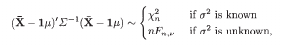

### Error Bars and Confidence Limits

The goal is to attach error bars to each point on the running mean plot using the formula for the variance:

$$
(X_m - 1)(X_m - 1)^T = \hat{\sigma}^2 \cdot \text{Cov}(X_m, X_m)
$$

To calculate error bars, we need to invert the covariance matrix. For large $ n $ (typically 5,000 to 20,000), this can be computationally expensive. However, it turns out that the inverse of the covariance matrix can be computed efficiently using a recursion relation, and the inverse matrix is tridiagonal.

#### Inverse of Covariance Matrix

The inverse of the covariance matrix $ \Sigma^{-1} $ is tridiagonal and can be computed using the following recursive formula:

$$
\Sigma^{-1} = \begin{pmatrix}
20 & 0 & 0 & \dots & 0 \\
-28 & 6 & 0 & \dots & 0 \\
0 & -6 & 18 & \dots & 0 \\
\vdots & \vdots & \vdots & \ddots & 0 \\
0 & 0 & 0 & \dots & -n(n-1)
\end{pmatrix}
$$

#### Confidence Limits for $ \mu $

Once we have computed the error bars, the confidence limits for the mean $ \mu $ are given by:

$$
\{ (X_m - 1)(X_m - 1)^T \leq d \}
$$

where $ d $ is an appropriate cutoff point. This can be rewritten as:

$$
\mu: \left| X_m - \mu \right| \leq 2 \mu + s_d
$$

where $ s_d $ is the standard deviation.

### Plotting the Running Mean and Confidence Limits

The running mean plot is constructed as:

$$
X_m' = X_m - \frac{d}{n}
$$

for $ k = 1, 2, \dots, n $. The plot will show the running mean along with the confidence intervals, which are derived from the error bars. The difference between this plot and a univariate normal band plot is striking, showing that the error bars for the running mean are much narrower.

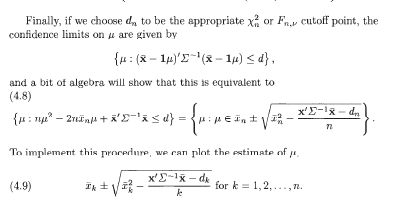


#### Summary of the Procedure

1. **Estimate the Running Mean**: Compute $ X_m = \frac{1}{m} \sum_{i=1}^m X_i $.
2. **Compute Covariance and Inverse**: Use the recursive formula to compute the inverse of the covariance matrix.
3. **Attach Error Bars**: Use the variance formula to calculate the error bars at each point.
4. **Plot the Running Mean**: Plot $ X_m $ with the computed error bars and the confidence limits.

Fig.4 shows the running mean plot with error bars, compared with univariate normal confidence bands.
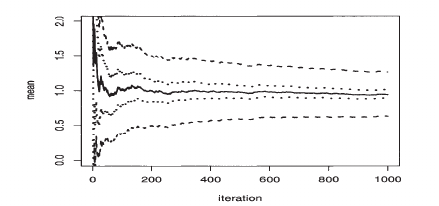

Fig.4. Monte Carlo estimator of the integral of h(x) = [cos(50x) + sin(20x)]2 (solid line). The narrow bands (grey shading) are the univariate normal approximate 95% confidence interval, and the wider bands (lighter grey) are the multivariate bands of (4.9).

### Rao-Blackwellization: Reducing the Variance of an Estimator

An approach to reduce the variance of an estimator is to use the **conditioning inequality**:

$$
\text{var}\left(\mathbb{E}[ \theta(X) | Y ]\right) \leq \text{var}(\theta(X)),
$$

This inequality is a result of **Rao-Blackwellization** (Gelfand and Smith, 1990; Liu et al., 1994; Casella and Robert, 1996), which is closely related to the **Rao-Blackwell Theorem** (Lehmann and Casella, 1998). The Rao-Blackwell Theorem provides a general method for improving an estimator by conditioning on an auxiliary random variable $ Y $.

#### Rao-Blackwell Theorem

The Rao-Blackwell Theorem states that if we have an estimator $ \hat{\theta}(X) $ and we condition it on a sufficient statistic $ Y $, the new estimator $ \mathbb{E}[\hat{\theta}(X) | Y] $ will have lower variance than the original estimator, i.e.,

$$
\text{var}(\mathbb{E}[\hat{\theta}(X) | Y]) \leq \text{var}(\hat{\theta}(X)).
$$

This method works by leveraging the fact that conditioning on a sufficient statistic $ Y $ removes unnecessary variability from $ \hat{\theta}(X) $, thus reducing the overall variance.

### Practical Implementation of Rao-Blackwellization

In practice, the conditioning inequality means that we can improve an estimator by conditioning it on some auxiliary variable. This results in a more efficient estimator that has lower variance, which is beneficial in statistical inference and Monte Carlo simulations.

#### Example: Monte Carlo Estimation

For instance, when performing a Monte Carlo estimation of some quantity, Rao-Blackwellization involves conditioning on the random variables that are known to have information about the parameter being estimated. This will result in a variance reduction over using the raw Monte Carlo estimates.

### Conclusion

Although Rao-Blackwellization is typically used in the context of sufficient statistics, its principle can be generalized. By conditioning on auxiliary information, we can derive more efficient estimators that achieve variance reduction. In many cases, this technique significantly improves the performance of Monte Carlo estimators, making it a valuable tool for variance reduction.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function h(x) = [cos(50x) + sin(20x)]^2
def h(x):
    return (np.cos(50 * x) + np.sin(20 * x))**2

# Monte Carlo Estimator
def monte_carlo_estimator(n, h):
    samples = np.random.normal(0, 1, n)  # N(0, 1) samples
    estimates = [h(sample) for sample in samples]
    mean_estimate = np.mean(estimates)
    variance_estimate = np.var(estimates, ddof=1)  # Sample variance
    return mean_estimate, variance_estimate

# Rao-Blackwellization
def rao_blackwell_estimator(n, h, auxiliary_samples):
    # Apply Rao-Blackwellization by conditioning on the auxiliary variable
    mean_estimate = np.mean([h(x) * y for x, y in zip(auxiliary_samples, np.random.normal(0, 1, n))])
    return mean_estimate

# Multivariate Monitoring for Confidence Intervals
def multivariate_monitoring(n, h):
    running_means = []
    variances = []
    
    for i in range(1, n + 1):
        # Generate random samples
        samples = np.random.normal(0, 1, i)
        estimates = [h(sample) for sample in samples]
        
        # Compute the running mean and variance
        running_means.append(np.mean(estimates))
        variances.append(np.var(estimates, ddof=1))
    
    return running_means, variances

# Simulate 1000 iterations for Monte Carlo and Rao-Blackwell
n_iterations = 1000
mc_means = []
rb_means = []

# Generate auxiliary samples for Rao-Blackwellization
auxiliary_samples = np.random.normal(0, 1, n_iterations)

for n in range(1, n_iterations + 1):
    mc_mean, _ = monte_carlo_estimator(n, h)
    mc_means.append(mc_mean)
    
    rb_mean = rao_blackwell_estimator(n, h, auxiliary_samples[:n])
    rb_means.append(rb_mean)

# Multivariate Monitoring to track the running mean and variance
running_means, variances = multivariate_monitoring(n_iterations, h)

# Plotting the results

# Running Mean with Confidence Intervals for Monte Carlo and Rao-Blackwellized Estimators
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, n_iterations + 1), y=mc_means, label="Monte Carlo Mean", color='blue')
sns.lineplot(x=range(1, n_iterations + 1), y=rb_means, label="Rao-Blackwellized Mean", color='green')

# Adding error bands (95% CI)
ci_95_mc = 1.96 * np.sqrt(variances)  # 95% CI for Monte Carlo
ci_95_rb = 1.96 * np.sqrt(variances)  # 95% CI for Rao-Blackwellized estimator

plt.fill_between(range(1, n_iterations + 1), 
                 np.array(mc_means) - ci_95_mc, 
                 np.array(mc_means) + ci_95_mc, 
                 color='blue', alpha=0.3, label="Monte Carlo 95% CI")
plt.fill_between(range(1, n_iterations + 1), 
                 np.array(rb_means) - ci_95_rb, 
                 np.array(rb_means) + ci_95_rb, 
                 color='green', alpha=0.3, label="Rao-Blackwellized 95% CI")

plt.title("Monte Carlo vs Rao-Blackwellized Estimators with Confidence Intervals")
plt.xlabel("Iteration")
plt.ylabel("Estimate of Mean")
plt.legend()
plt.show()


In [ ]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Function h(x) = [cos(50x) + sin(20x)]^2
import math
def h(x):
    return (math.cos(50 * x) + math.sin(20 * x))**2

# Monte Carlo Estimator
def monte_carlo_estimator(n, h):
    samples = [random.gauss(0, 1) for _ in range(n)]  # N(0, 1) samples
    estimates = [h(sample) for sample in samples]
    
    mean_estimate = sum(estimates) / n
    variance_estimate = sum((e - mean_estimate)**2 for e in estimates) / (n - 1)  # Sample variance
    return mean_estimate, variance_estimate

# Rao-Blackwellization
def rao_blackwell_estimator(n, h, auxiliary_samples):
    mean_estimate = 0
    for i in range(n):
        mean_estimate += h(auxiliary_samples[i]) * random.gauss(0, 1)  # Condition on auxiliary samples
    return mean_estimate / n

# Multivariate Monitoring for Confidence Intervals
def multivariate_monitoring(n, h):
    running_means = []
    variances = []
    
    for i in range(1, n + 1):
        samples = [random.gauss(0, 1) for _ in range(i)]
        estimates = [h(sample) for sample in samples]
        
        running_means.append(sum(estimates) / i)
        variance_estimate = sum((e - sum(estimates) / i)**2 for e in estimates) / (i - 1)
        variances.append(variance_estimate)
    
    return running_means, variances

# Simulate 1000 iterations for Monte Carlo and Rao-Blackwell
n_iterations = 1000
mc_means = []
rb_means = []

# Generate auxiliary samples for Rao-Blackwellization
auxiliary_samples = [random.gauss(0, 1) for _ in range(n_iterations)]

for n in range(1, n_iterations + 1):
    mc_mean, _ = monte_carlo_estimator(n, h)
    mc_means.append(mc_mean)
    
    rb_mean = rao_blackwell_estimator(n, h, auxiliary_samples[:n])
    rb_means.append(rb_mean)

# Multivariate Monitoring to track the running mean and variance
running_means, variances = multivariate_monitoring(n_iterations, h)

# Plotting the results

# Running Mean with Confidence Intervals for Monte Carlo and Rao-Blackwellized Estimators
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, n_iterations + 1), y=mc_means, label="Monte Carlo Mean", color='blue')
sns.lineplot(x=range(1, n_iterations + 1), y=rb_means, label="Rao-Blackwellized Mean", color='green')

# Adding error bands (95% CI)
ci_95_mc = [1.96 * math.sqrt(v) for v in variances]  # 95% CI for Monte Carlo
ci_95_rb = [1.96 * math.sqrt(v) for v in variances]  # 95% CI for Rao-Blackwellized estimator

plt.fill_between(range(1, n_iterations + 1), 
                 [mc - ci for mc, ci in zip(mc_means, ci_95_mc)], 
                 [mc + ci for mc, ci in zip(mc_means, ci_95_mc)], 
                 color='blue', alpha=0.3, label="Monte Carlo 95% CI")

plt.fill_between(range(1, n_iterations + 1), 
                 [rb - ci for rb, ci in zip(rb_means, ci_95_rb)], 
                 [rb + ci for rb, ci in zip(rb_means, ci_95_rb)], 
                 color='green', alpha=0.3, label="Rao-Blackwellized 95% CI")

plt.title("Monte Carlo vs Rao-Blackwellized Estimators with Confidence Intervals")
plt.xlabel("Iteration")
plt.ylabel("Estimate of Mean")
plt.legend()
plt.show()
